<a href="https://colab.research.google.com/github/AnkitaSavaliya/AIH/blob/main/AIH/Class/sepsis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
# Load the required datasets
patients = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AIH/MIMIC-IV-DATASET/hosp/patients.csv.gz')  # Patient demographics
admissions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AIH/MIMIC-IV-DATASET/hosp/admissions.csv.gz')  # Admission details
chartevents = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AIH/MIMIC-IV-DATASET/icu/chartevents.csv.gz')  # Clinical vital signs (chartevents)
labevents = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AIH/MIMIC-IV-DATASET/hosp/labevents.csv.gz')  # Lab test results
diagnoses_icd = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AIH/MIMIC-IV-DATASET/hosp/diagnoses_icd.csv.gz')  # Sepsis diagnoses (ICD codes)


In [73]:
# Merge the patients and admissions data
df = patients[['subject_id', 'gender', 'anchor_age']]
df = pd.merge(df, admissions[['subject_id', 'admittime', 'dischtime', 'admission_type', 'hadm_id']], on='subject_id', how='left')

# Convert date columns to datetime
#df['age'] = pd.to_datetime(df['anchor_age'])
df['admittime'] = pd.to_datetime(df['admittime'])
df['dischtime'] = pd.to_datetime(df['dischtime'])

df.head()

,subject_id,gender,anchor_age,admittime,dischtime,admission_type,hadm_id
0,10014729,F,21,2125-03-19 16:58:00,2125-03-28 13:37:00,EW EMER.,23300884
1,10014729,F,21,2125-02-27 07:15:00,2125-03-06 14:25:00,SURGICAL SAME DAY ADMISSION,28889419
2,10003400,F,72,2137-08-04 00:07:00,2137-09-02 17:05:00,URGENT,23559586
3,10003400,F,72,2137-02-24 10:00:00,2137-03-19 15:45:00,URGENT,20214994
4,10003400,F,72,2136-12-31 21:40:00,2137-01-03 17:05:00,EW EMER.,27296885


In [74]:
# Calculate age at the time of admission
#df['age'] = (df['admittime'] - df['dob']).dt.days // 365

# Convert gender to numeric (0 for male, 1 for female)
df['gender'] = df['gender'].map({'M': 0, 'F': 1})

In [75]:
df.head()

,subject_id,gender,anchor_age,admittime,dischtime,admission_type,hadm_id
0,10014729,1,21,2125-03-19 16:58:00,2125-03-28 13:37:00,EW EMER.,23300884
1,10014729,1,21,2125-02-27 07:15:00,2125-03-06 14:25:00,SURGICAL SAME DAY ADMISSION,28889419
2,10003400,1,72,2137-08-04 00:07:00,2137-09-02 17:05:00,URGENT,23559586
3,10003400,1,72,2137-02-24 10:00:00,2137-03-19 15:45:00,URGENT,20214994
4,10003400,1,72,2136-12-31 21:40:00,2137-01-03 17:05:00,EW EMER.,27296885


In [76]:
# Calculate length of stay in hospital
df['length_of_stay'] = (df['dischtime'] - df['admittime']).dt.days

# Encode admission type as categorical (1 for emergency, 0 for elective)
df['admission_type'] = df['admission_type'].map({'EMERGENCY': 1, 'ELECTIVE': 0, 'URGENT': 1})


In [77]:
df.head()

,subject_id,gender,anchor_age,admittime,dischtime,admission_type,hadm_id,length_of_stay
0,10014729,1,21,2125-03-19 16:58:00,2125-03-28 13:37:00,NaN,23300884,8
1,10014729,1,21,2125-02-27 07:15:00,2125-03-06 14:25:00,NaN,28889419,7
2,10003400,1,72,2137-08-04 00:07:00,2137-09-02 17:05:00,1.0,23559586,29
3,10003400,1,72,2137-02-24 10:00:00,2137-03-19 15:45:00,1.0,20214994,23
4,10003400,1,72,2136-12-31 21:40:00,2137-01-03 17:05:00,NaN,27296885,2


In [78]:
# remove NAN from admission_type
df.dropna(subset=['admission_type'], inplace=True)

In [79]:
df.head()

,subject_id,gender,anchor_age,admittime,dischtime,admission_type,hadm_id,length_of_stay
2,10003400,1,72,2137-08-04 00:07:00,2137-09-02 17:05:00,1.0,23559586,29
3,10003400,1,72,2137-02-24 10:00:00,2137-03-19 15:45:00,1.0,20214994,23
18,10027445,1,48,2145-12-08 19:47:00,2145-12-19 14:36:00,1.0,27488741,10
19,10027445,1,48,2142-08-27 21:05:00,2142-09-05 17:33:00,1.0,29163082,8
32,10040025,1,64,2147-12-29 19:36:00,2148-01-09 17:38:00,0.0,25933959,10


In [80]:
# Example item IDs for important vital signs
heart_rate_itemid = 220045
bp_itemid = 220050
resp_rate_itemid = 220210 #220179
temperature_itemid = 223762

# Filter data for vital signs from chartevents
vitals = chartevents[chartevents['itemid'].isin([heart_rate_itemid, bp_itemid, resp_rate_itemid, temperature_itemid])]

# Aggregate the data by subject_id and itemid (get the last recorded measurement)
vitals = vitals.groupby(['subject_id', 'itemid'])['value'].last().unstack().reset_index()

# Rename columns for clarity
vitals.columns = ['subject_id', 'heart_rate', 'blood_pressure', 'respiratory_rate', 'temperature']


In [81]:
vitals.head(), len(vitals)

(   subject_id heart_rate blood_pressure respiratory_rate temperature
 0    10000032         93            NaN               21         NaN
 1    10001217         98            NaN               13         NaN
 2    10001725         55            NaN               15         NaN
 3    10002428         92            109               17         NaN
 4    10002495        113            127               25         NaN,
 100)

In [82]:
# Example item IDs for relevant lab tests
lactate_itemid = 220546
wbc_itemid = 50931
creatinine_itemid = 50912

# Filter relevant lab results from labevents
labs = labevents[labevents['itemid'].isin([lactate_itemid, wbc_itemid, creatinine_itemid])]

# Aggregate the lab results by subject_id
labs = labs.groupby(['subject_id', 'itemid'])['value'].last().unstack().reset_index()

# Rename columns for clarity
#labs.columns = ['subject_id', 'lactate', 'wbc', 'creatinine']

labs.head()

itemid,subject_id,50912,50931
0,10000032,0.4,___
1,10001217,0.4,___
2,10001725,0.8,___
3,10002428,0.5,___
4,10002495,1.6,___


In [83]:
# Merge all data (vitals, labs, and demographics/admission info)
df = pd.merge(df, vitals, on='subject_id', how='left')
df = pd.merge(df, labs, on='subject_id', how='left')

df.head()

,subject_id,gender,anchor_age,admittime,dischtime,admission_type,hadm_id,length_of_stay,heart_rate,blood_pressure,respiratory_rate,temperature,50912,50931
0,10003400,1,72,2137-08-04 00:07:00,2137-09-02 17:05:00,1.0,23559586,29,97,90,20,NaN,1.4,___
1,10003400,1,72,2137-02-24 10:00:00,2137-03-19 15:45:00,1.0,20214994,23,97,90,20,NaN,1.4,___
2,10027445,1,48,2145-12-08 19:47:00,2145-12-19 14:36:00,1.0,27488741,10,126,111,29,NaN,0.7,___
3,10027445,1,48,2142-08-27 21:05:00,2142-09-05 17:33:00,1.0,29163082,8,126,111,29,NaN,0.7,___
4,10040025,1,64,2147-12-29 19:36:00,2148-01-09 17:38:00,0.0,25933959,10,83,NaN,12,NaN,2.4,___


In [86]:
print(df.head(), len(df))

   subject_id  gender  anchor_age           admittime           dischtime  \
0    10003400       1          72 2137-08-04 00:07:00 2137-09-02 17:05:00   
1    10003400       1          72 2137-02-24 10:00:00 2137-03-19 15:45:00   
2    10027445       1          48 2145-12-08 19:47:00 2145-12-19 14:36:00   
3    10027445       1          48 2142-08-27 21:05:00 2142-09-05 17:33:00   
4    10040025       1          64 2147-12-29 19:36:00 2148-01-09 17:38:00   

   admission_type   hadm_id  length_of_stay heart_rate blood_pressure  \
0             1.0  23559586              29         97             90   
1             1.0  20214994              23         97             90   
2             1.0  27488741              10        126            111   
3             1.0  29163082               8        126            111   
4             0.0  25933959              10         83            NaN   

  respiratory_rate temperature 50912 50931  
0               20         NaN   1.4   ___  
1       

In [87]:
# Define ICD codes for sepsis
sepsis_icd_codes = ['A41', 'R65', '995.91']

# Filter for patients with sepsis-related diagnoses
sepsis_patients = diagnoses_icd[diagnoses_icd['icd_code'].isin(sepsis_icd_codes)]

# 2. Mark sepsis patients in the dataframe (1 if sepsis diagnosis exists)
sepsis_patients = sepsis_patients[['subject_id']].drop_duplicates()

# 3. Merge with the patients dataframe to ensure we have all patient data (both sepsis and non-sepsis)
# Here, we use `how='left'` to keep all patients, even those without sepsis diagnosis
df = pd.merge(patients[['subject_id']], sepsis_patients, on='subject_id', how='left')

# 4. Mark sepsis patients as 1 (sepsis), others as 0 (non-sepsis)
# If there's no sepsis diagnosis, the merge will result in NaN, so we mark those as 0
df['sepsis'] = df['subject_id'].notnull().astype(int)

# Now df will have both sepsis (1) and non-sepsis (0) patients
df.head()



,subject_id,sepsis
0,10014729,1
1,10003400,1
2,10002428,1
3,10032725,1
4,10027445,1


In [88]:
df['sepsis'].value_counts()

,count
sepsis,
1,100


In [30]:
df.head()

,subject_id,gender,anchor_age,admittime,dischtime,admission_type,hadm_id,length_of_stay,heart_rate_x,blood_pressure_x,...,temperature_x,50912_x,50931_x,heart_rate_y,blood_pressure_y,respiratory_rate_y,temperature_y,50912_y,50931_y,sepsis
0,10003400,1,72,2137-08-04 00:07:00,2137-09-02 17:05:00,1.0,23559586,29,97,90,...,NaN,1.4,___,97,90,20,NaN,1.4,___,1
1,10003400,1,72,2137-02-24 10:00:00,2137-03-19 15:45:00,1.0,20214994,23,97,90,...,NaN,1.4,___,97,90,20,NaN,1.4,___,1
2,10027445,1,48,2145-12-08 19:47:00,2145-12-19 14:36:00,1.0,27488741,10,126,111,...,NaN,0.7,___,126,111,29,NaN,0.7,___,1
3,10027445,1,48,2142-08-27 21:05:00,2142-09-05 17:33:00,1.0,29163082,8,126,111,...,NaN,0.7,___,126,111,29,NaN,0.7,___,1
4,10040025,1,64,2147-12-29 19:36:00,2148-01-09 17:38:00,0.0,25933959,10,83,NaN,...,NaN,2.4,___,83,NaN,12,NaN,2.4,___,1


In [31]:
df['sepsis'].value_counts()

,count
sepsis,
1,51


In [32]:
# Fill missing values for numerical columns (with the column mean)
df.fillna(df.mean(), inplace=True)

# Fill missing values for categorical columns (with the column mode)
df['gender'].fillna(df['gender'].mode()[0], inplace=True)
df['admission_type'].fillna(df['admission_type'].mode()[0], inplace=True)


TypeError: can only concatenate str (not "int") to str

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, 26 to 50
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   subject_id          11 non-null     int64         
 1   gender              11 non-null     int64         
 2   anchor_age          11 non-null     int64         
 3   admittime           11 non-null     datetime64[ns]
 4   dischtime           11 non-null     datetime64[ns]
 5   admission_type      11 non-null     float64       
 6   hadm_id             11 non-null     int64         
 7   length_of_stay      11 non-null     int64         
 8   heart_rate_x        11 non-null     object        
 9   blood_pressure_x    11 non-null     object        
 10  respiratory_rate_x  11 non-null     object        
 11  temperature_x       11 non-null     object        
 12  50912_x             11 non-null     object        
 13  50931_x             11 non-null     object        
 14  

In [38]:
# remove NAN from admission_type
df.dropna(subset=['temperature_x'], inplace=True)

In [43]:
df.head()

,subject_id,gender,anchor_age,admittime,dischtime,admission_type,hadm_id,length_of_stay,heart_rate_x,blood_pressure_x,...,temperature_x,50912_x,50931_x,heart_rate_y,blood_pressure_y,respiratory_rate_y,temperature_y,50912_y,50931_y,sepsis
26,10021487,0,43,2117-07-16 07:15:00,2117-07-25 12:34:00,0.0,20429160,9,128,110,...,36.9,0.6,___,128,110,18,36.9,0.6,___,1
30,10005348,0,76,2128-09-05 08:30:00,2128-09-12 16:55:00,0.0,29496232,7,84,95,...,35,0.9,___,84,95,9,35,0.9,___,1
31,10009035,0,28,2161-04-27 07:15:00,2161-05-01 13:45:00,0.0,28324362,4,91,115,...,36.2,1.0,___,91,115,12,36.2,1.0,___,1
33,10037975,0,60,2185-01-17 19:11:00,2185-01-22 14:25:00,1.0,27617929,4,133,91,...,39.6,4.1,___,133,91,37,39.6,4.1,___,1
34,10035185,0,70,2120-05-12 12:53:00,2120-05-17 16:00:00,1.0,22580999,5,69,105,...,35,1.4,___,69,105,16,35,1.4,___,1


In [45]:
# Define the features to use for prediction
features = ['heart_rate_x', 'blood_pressure_x', 'respiratory_rate_x', 'temperature_x',
              'gender', 'length_of_stay', 'admission_type']

# features = ['heart_rate', 'blood_pressure', 'respiratory_rate', 'temperature',
#             'lactate', 'wbc', 'creatinine', 'age', 'gender', 'length_of_stay', 'admission_type']

#features = pd.get_dummies(features, drop_first=True)

df[features]

,heart_rate_x,blood_pressure_x,respiratory_rate_x,temperature_x,gender,length_of_stay,admission_type
26,128,110,18,36.9,0,9,0.0
30,84,95,9,35,0,7,0.0
31,91,115,12,36.2,0,4,0.0
33,133,91,37,39.6,0,4,1.0
34,69,105,16,35,0,5,1.0
38,64,95,23,31.1,0,8,1.0
44,82,63,18,37.2,0,8,1.0
46,120,130,24,34.7,0,1,1.0
47,95,131,21,35.5,0,7,1.0
49,68,101,14,36.2,0,7,1.0


In [46]:
# Standardize the numerical features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

In [47]:
# Define target variable (sepsis)
X = df[features]
y = df['sepsis']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# Initialize and train the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [49]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         3

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3

Confusion Matrix:
 [[3]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


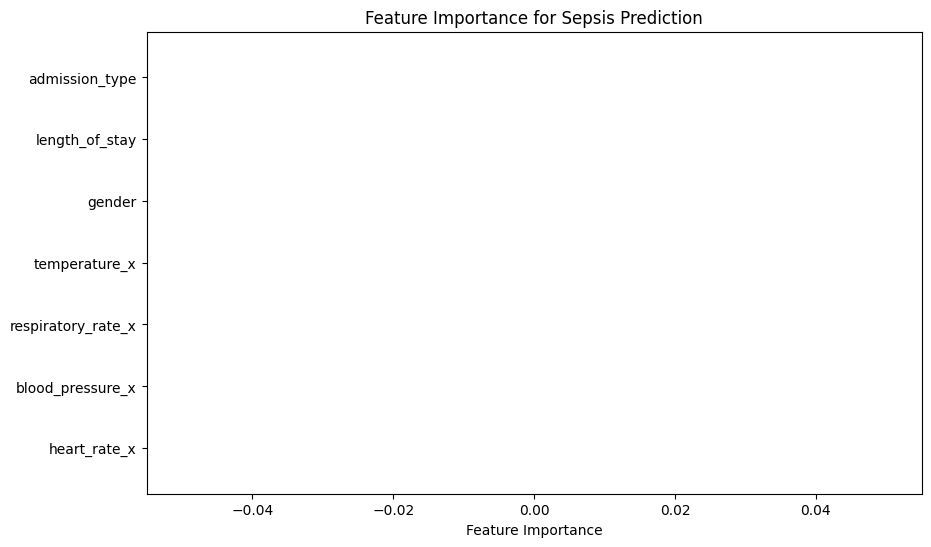

In [50]:
# Plot feature importances
feature_importances = model.feature_importances_
sorted_idx = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features)[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance for Sepsis Prediction")
plt.show()
